# Choosing variables for model

In this notebook, we will explore some basic criteria for variable selection within models, along with the difference between qualitative and quantitative variables. It can sometimes be helpful to reduce the number, or dimensions, of variables being used to create models when it comes to visualizing and interpreting results of the model. In most cases, with dimensions higher than three, it becomes complicated to present correlations of a model in an understandable fashion. We therefore would like to find some way to evaluate and compare different combinations of variables, to see which gives the lowest mean square error of new data.

As you've probably noticed, mean square error of new data is usually the go-to criteria when comparing model's since if gives a precise measurement of the efficiency of our model. 


## Quantitative vs. Qualitative data

In [Linear, Logarithmic, and Polynomial Regressions](/LinearLogarithmicPolynomialRegressions.ipynb) we looked at a data set where both variables consisted of _quantitative data._ This means that the data had some number value. But not all data needs to have some innate, number value. Take for example flipping a coin, or comparing a placebo to a medicine, or a person's gender. All of these are examples of some non-numeric characteristics data can have. Categorical data like the ones mentioned here is called _qualitative data_. 

Let's read in a data set containing some qualitative data.


In [6]:
oral_ca <- read.csv("oral_ca.csv", header = TRUE)
str(oral_ca)
summary(oral_ca)

'data.frame':	397 obs. of  7 variables:
 $ drinks  : num  11.1 0 48 13 76 ...
 $ ccstatus: int  1 1 1 1 1 1 1 1 1 1 ...
 $ cigs    : int  20 6 20 10 40 40 40 20 30 20 ...
 $ age     : int  52 54 47 39 47 47 37 61 59 36 ...
 $ sex     : int  0 0 0 0 1 0 0 0 0 0 ...
 $ M_drinks: int  0 0 0 0 0 0 0 0 0 0 ...
 $ M_cigs  : int  0 0 0 0 0 0 0 0 0 0 ...


     drinks          ccstatus           cigs            age    
 Min.   :  0.00   Min.   :0.0000   Min.   : 0.00   Min.   :21  
 1st Qu.:  1.50   1st Qu.:0.0000   1st Qu.: 3.00   1st Qu.:48  
 Median : 15.75   Median :0.0000   Median :20.00   Median :56  
 Mean   : 31.40   Mean   :0.4887   Mean   :16.36   Mean   :56  
 3rd Qu.: 48.00   3rd Qu.:1.0000   3rd Qu.:20.00   3rd Qu.:65  
 Max.   :140.00   Max.   :1.0000   Max.   :60.00   Max.   :80  
      sex            M_drinks            M_cigs       
 Min.   :0.0000   Min.   :0.000000   Min.   :0.00000  
 1st Qu.:0.0000   1st Qu.:0.000000   1st Qu.:0.00000  
 Median :0.0000   Median :0.000000   Median :0.00000  
 Mean   :0.2771   Mean   :0.005038   Mean   :0.01511  
 3rd Qu.:1.0000   3rd Qu.:0.000000   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :1.000000   Max.   :1.00000  

As we can somewhat see in the output above, there are some variables with discrete values of either 0 or 1 (ccstatus & sex). 

### Frequencies and probabilities

We begin by looking at the correlation between _ccstatus_ and _cigs_ as a dichotomized variable. The table below shows the observed frequencies of cases and controls for observations in the non-smokers and smokers groups. We observe that the number of smokers in the dataset is about three times larger than the number of non-smokers, and also that the majority of smokers are in the case group, while the majority of non-smokers are in the control group.


In [9]:
library(tidyverse)
options(warn=1)

oral_ca <- oral_ca %>%
    mutate(cigs.d = ifelse(cigs > 0, "Smokers", "Non-smokers"),
    ccstatus.d = ifelse(ccstatus == 1, "Case", "Control"))
table(oral_ca$cigs.d, oral_ca$ccstatus.d)


             
              Case Control
  Non-smokers   22      69
  Smokers      172     134

We can also compute the estimated probabilities, with their standard errors, of being a case for each of the groups (“Smokers” and “Non-smokers”). The results are shown below. We also include the probability for being a case for the observations in the sample as a whole. The estimated probability of a smoker being a case is approximately 0.562, with a standard error of 0.028. For a non-smoker the corresponding numbers are 0.242 and 0.045. (For the whole sample the estimated probability is 0.489 with a standard error of 0.025.)

In [10]:
probs <- oral_ca %>%
    summarise(pi.smoke.hat =
        sum(ccstatus[cigs.d == "Smokers"]) / sum(cigs.d == "Smokers"),
    pi.nonsmoke.hat =
        sum(ccstatus[cigs.d == "Non-smokers"]) / sum(cigs.d == "Non-smokers"),
    pi.common.hat =
        sum(ccstatus) / n(),
    se.pi.smoke.hat =
        sqrt(pi.smoke.hat * (1 - pi.smoke.hat) / sum(cigs.d == "Smokers")),
    se.pi.nonsmoke.hat =
        sqrt(pi.nonsmoke.hat * (1 - pi.nonsmoke.hat) / sum(cigs.d == "Non-smokers")),
    se.pi.common.hat =
        sqrt(pi.common.hat * (1 - pi.common.hat) / n()))

t(probs)

pi.smoke.hat,0.56209150
pi.nonsmoke.hat,0.24175824
pi.common.hat,0.48866499
se.pi.smoke.hat,0.02836185
se.pi.nonsmoke.hat,0.04488216
se.pi.common.hat,0.02508783


### Test for equal probabilities

Using the estimated probabilities and their standard errors from above, we compute the likelihood ratio test statistics, _w_. This test statistics is 2(log(L1)–log(L0)) where L0 is the maximized loglikelihood function under the null hypothesis that the probabilities are equal (i.e. does not depend
upon being a smoker or not) and L1 the maximized log-likelihood function without that constraint (Azzalini & Scarpa, 2012). We also compute the p-value of w based on the chi-squared distribution with 1 df. As the p-value is close to zero, we reject the null hypothesis of equal probability.


In [11]:
res <- oral_ca %>%
    summarise(llik_pi.smoke.hat_pi.nonsmoke.hat =
        sum(dbinom(ccstatus[cigs.d == "Smokers"], 1, probs$pi.smoke.hat, log = TRUE)) +
        sum(dbinom(ccstatus[cigs.d == "Non-smokers"], 1, probs$pi.nonsmoke.hat, log = TRUE)),
    llik_pi.common.hat = sum(dbinom(ccstatus, 1, probs$pi.common.hat, log = TRUE)),
    w = 2 * (llik_pi.smoke.hat_pi.nonsmoke.hat - llik_pi.common.hat),
    p.value = 1 - pchisq(w, df = 1))
t(res)


llik_pi.smoke.hat_pi.nonsmoke.hat,-2.600694e+02
llik_pi.common.hat,-2.750774e+02
w,3.001603e+01
p.value,4.284888e-08


## Linear logistic model

### Dichotomized variable

Here we will fit a linear logistic model with cigarettes as a dichotomized variable. To fit a linear logistics model, we use the `glm` function, and the results are shown below. As the coefficient of cigs is positive and significant at less than 0.1 percent significance level, being a smoker seems to increase the risk of oral cancer. Specifically, the increase in log-odds from smoking is approximately 1.39. This corresponds to an increase in odds by the exponential of the log-odds, which is approximately 4.028. We can also see this by the calculation below. Furthermore, the intercept coefficient is the log-odds of cancer for the reference group of not being a smoker.

In [12]:
mod.c <- glm(ccstatus ~ cigs.d,
    family = "binomial",
    data = oral_ca)
summary(mod.c)


Call:
glm(formula = ccstatus ~ cigs.d, family = "binomial", data = oral_ca)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.285  -1.285  -0.744   1.073   1.685  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.1431     0.2448  -4.669 3.03e-06 ***
cigs.dSmokers   1.3927     0.2706   5.147 2.65e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.15  on 396  degrees of freedom
Residual deviance: 520.14  on 395  degrees of freedom
AIC: 524.14

Number of Fisher Scoring iterations: 4


In [13]:
beta <- mod.c$coefficients

pi_values <- data.frame(pi_smoke = exp(beta[1] + beta[2]) / (1 + exp(beta[1] + beta[2])),
    pi_nonsmoke = exp(beta[1]) / (1 + exp(beta[1])))

log_odds <- pi_values %>%
    mutate(odds_smoke = pi_smoke / (1 - pi_smoke),
        odds_nonsmoke = pi_nonsmoke / (1 - pi_nonsmoke),
        log_odds_smoke = log(odds_smoke),
        log_odds_nonsmoke = log(odds_nonsmoke),
        diff_log_odds = log_odds_smoke - log_odds_nonsmoke,
        diff_odds = exp(diff_log_odds))
t(log_odds)

pi_smoke,0.5620915
pi_nonsmoke,0.2417582
odds_smoke,1.2835821
odds_nonsmoke,0.3188406
log_odds_smoke,0.2496547
log_odds_nonsmoke,-1.1430641
diff_log_odds,1.3927187
diff_odds,4.0257802


### Continuous variable

Instead of using a dichotomized variable for cigs, we now use the continuous variable in the model. The results are shown below. The coefficient of cigs of approximately 0.054 is now the expected change (increase) in log-odds from one additional cigarette smoked per day. Although they are both related to the odds for non-smokers, the coefficient of the intercept changes with respect to pt. (c) because cigs is now a continuous variable.


In [14]:
mod.d <- glm(ccstatus ~ cigs,
    family = "binomial",
    data = oral_ca)
summary(mod.d)


Call:
glm(formula = ccstatus ~ cigs, family = "binomial", data = oral_ca)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1923  -1.0237  -0.8228   1.1088   1.5796  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.909057   0.171766  -5.292 1.21e-07 ***
cigs         0.053624   0.008614   6.225 4.81e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.15  on 396  degrees of freedom
Residual deviance: 504.39  on 395  degrees of freedom
AIC: 508.39

Number of Fisher Scoring iterations: 4


### All explanatory variables

We now include the other three variables (drinks, age and sex) in the model as well, and the results are shown below. Of the three variables, drinks and sex are significant at 5 percent significance level or less, and both have a positive correlation with the risk of oral cancer. The coefficient of the
variable age is also positive, but it is not significantly different from zero. Furthermore, we observe that the increase in the log-odds for one more cigarette smoked per day now is 0.035, which is a lower value than in pt. (d) where it was 0.054. The reason for this is that in pt. (d), the model
suffered from omitted variable bias. That is, one or more relevant variables correlating both with ccstatus and with cigs were left out of the model, resulting in the coefficient of cigs being estimated to be too high. Finally, we can notice that AIC is 453.8.



In [15]:
mod.e <- glm(ccstatus ~ cigs + drinks + age + sex,
    family = "binomial",
    data = oral_ca)
summary(mod.e)


Call:
glm(formula = ccstatus ~ cigs + drinks + age + sex, family = "binomial", 
    data = oral_ca)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7185  -0.8589  -0.5832   0.9644   1.9776  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.966071   0.620756  -3.167  0.00154 ** 
cigs         0.035480   0.009571   3.707  0.00021 ***
drinks       0.029623   0.004643   6.380 1.77e-10 ***
age          0.006529   0.009960   0.656  0.51213    
sex          0.594499   0.272752   2.180  0.02928 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.15  on 396  degrees of freedom
Residual deviance: 443.84  on 392  degrees of freedom
AIC: 453.84

Number of Fisher Scoring iterations: 5


### Excluding age 

The coefficient of age has a positive value, but it is not statistically significant at 5 percent level, thus we do not reject the null hypothesis that the coefficient is zero. Hence, it does not seem to be the case that older people risk more, controlling for the other variables (cigs, drinks and sex). We now fit a new model excluding age, and the results are shown below. Specifically, the coefficients of cigs, drinks and sex are more or less the same as in pt. (e), and AIC is slightly improved to 452.3. As the model without age is simpler than the model including age, and also improves AIC, I would
prefer this simpler model.

In [16]:
mod.f <- glm(ccstatus ~ cigs + drinks + sex,
    family = "binomial",
    data = oral_ca)
summary(mod.f)


Call:
glm(formula = ccstatus ~ cigs + drinks + sex, family = "binomial", 
    data = oral_ca)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6943  -0.8596  -0.6084   0.9607   1.8857  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.592919   0.238787  -6.671 2.54e-11 ***
cigs         0.035536   0.009565   3.715 0.000203 ***
drinks       0.029498   0.004638   6.360 2.01e-10 ***
sex          0.582183   0.271756   2.142 0.032169 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.15  on 396  degrees of freedom
Residual deviance: 444.27  on 393  degrees of freedom
AIC: 452.27

Number of Fisher Scoring iterations: 5


### Quadratic term for drinks

We still exclude age and instead include a polynomial of degree 2 to model the effect of drinks, where the results are shown below. The coefficients of all variables are statistically significant at a 5 percent significance level, and AIC is further improved to 447.6, compared to 452.3. Hence, including a polynomial of degree 2 appears to improve the model

In [17]:
mod.g <- glm(ccstatus ~ cigs + drinks + I(drinks^2) + sex,
    family = "binomial",
    data = oral_ca)
summary(mod.g)



Call:
glm(formula = ccstatus ~ cigs + drinks + I(drinks^2) + sex, family = "binomial", 
    data = oral_ca)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2192  -0.8379  -0.5405   0.8756   1.9980  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.850e+00  2.667e-01  -6.936 4.03e-12 ***
cigs         3.301e-02  9.642e-03   3.424 0.000618 ***
drinks       5.362e-02  1.052e-02   5.099 3.42e-07 ***
I(drinks^2) -2.295e-04  8.419e-05  -2.726 0.006405 ** 
sex          7.256e-01  2.854e-01   2.542 0.011007 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.15  on 396  degrees of freedom
Residual deviance: 437.62  on 392  degrees of freedom
AIC: 447.62

Number of Fisher Scoring iterations: 4


### Quadratic term for cigarettes

If we instead include a quadratic term for cigs, we get the results shown below. It appears that including a quadratic term for cigs does not improve the model as the coefficient of cigs$^2$ is not significant and AIC is increased to 453.6.

In [18]:
mod.h <- glm(ccstatus ~ cigs + I(cigs^2) + drinks + sex,
    family = "binomial",
    data = oral_ca)
summary(mod.h)



Call:
glm(formula = ccstatus ~ cigs + I(cigs^2) + drinks + sex, family = "binomial", 
    data = oral_ca)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6870  -0.8764  -0.5808   0.9695   1.9303  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.6943120  0.2697349  -6.281 3.36e-10 ***
cigs         0.0541177  0.0238775   2.266   0.0234 *  
I(cigs^2)   -0.0004485  0.0005225  -0.858   0.3907    
drinks       0.0289791  0.0046347   6.253 4.04e-10 ***
sex          0.6019008  0.2742844   2.194   0.0282 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.15  on 396  degrees of freedom
Residual deviance: 443.55  on 392  degrees of freedom
AIC: 453.55

Number of Fisher Scoring iterations: 5


### Cubic terms

Finally, we can build models including a cubic term for drinks and cigs, respectively, to see if that improves the fit. However, as the results below show, neither models appear to be an improvement compared to the simpler ones, as the coefficients of the second and third order polynomials are not statistically significant in any of the models. Also, AIC is worse in both models compared to the AIC of the model in pt. (g). Hence, the best model seems to be the one with quadratic effect for drinks.

##### Drinks


In [19]:
mod.i1 <- glm(ccstatus ~ cigs + drinks + I(drinks^2) + I(drinks^3) + sex,
                family = "binomial",
                data = oral_ca)
summary(mod.i1)



Call:
glm(formula = ccstatus ~ cigs + drinks + I(drinks^2) + I(drinks^3) + 
    sex, family = "binomial", data = oral_ca)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1993  -0.8382  -0.5367   0.8703   2.0045  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.865e+00  2.876e-01  -6.484 8.91e-11 ***
cigs         3.294e-02  9.651e-03   3.413 0.000642 ***
drinks       5.636e-02  2.197e-02   2.565 0.010323 *  
I(drinks^2) -2.960e-04  4.748e-04  -0.623 0.532963    
I(drinks^3)  3.540e-07  2.488e-06   0.142 0.886856    
sex          7.320e-01  2.893e-01   2.530 0.011390 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.15  on 396  degrees of freedom
Residual deviance: 437.60  on 391  degrees of freedom
AIC: 449.6

Number of Fisher Scoring iterations: 4


###### Cigarettes

In [20]:
mod.i2 <- glm(ccstatus ~ cigs + I(cigs^2) + I(cigs^3) + drinks + sex,
                family = "binomial",
                data = oral_ca)
summary(mod.i2)



Call:
glm(formula = ccstatus ~ cigs + I(cigs^2) + I(cigs^3) + drinks + 
    sex, family = "binomial", data = oral_ca)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6567  -0.8871  -0.5658   0.9740   1.9551  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.751e+00  2.863e-01  -6.116 9.58e-10 ***
cigs         7.879e-02  4.579e-02   1.721   0.0853 .  
I(cigs^2)   -1.901e-03  2.361e-03  -0.805   0.4208    
I(cigs^3)    2.011e-05  3.215e-05   0.626   0.5316    
drinks       2.896e-02  4.643e-03   6.238 4.43e-10 ***
sex          6.144e-01  2.752e-01   2.232   0.0256 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.15  on 396  degrees of freedom
Residual deviance: 443.15  on 391  degrees of freedom
AIC: 455.15

Number of Fisher Scoring iterations: 5


## Overview 

Finally, we examine which model is the best for prediction by splitting the data into a training set and a test set, where we use 3/4 of the data for training and 1/4 for testing. To ensure that results can be repeated, we use set.seed. However, it should be noticed that the computed errors of the training and test data for the different models will depend on the split into training and test. If the data were split using a different set.seed value, the results may change.

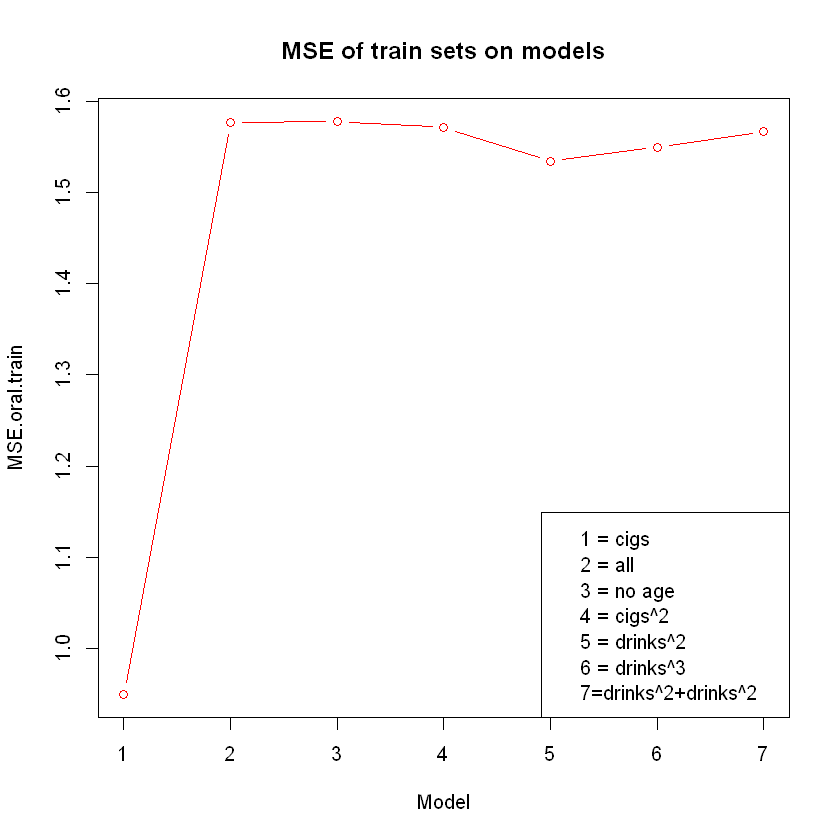

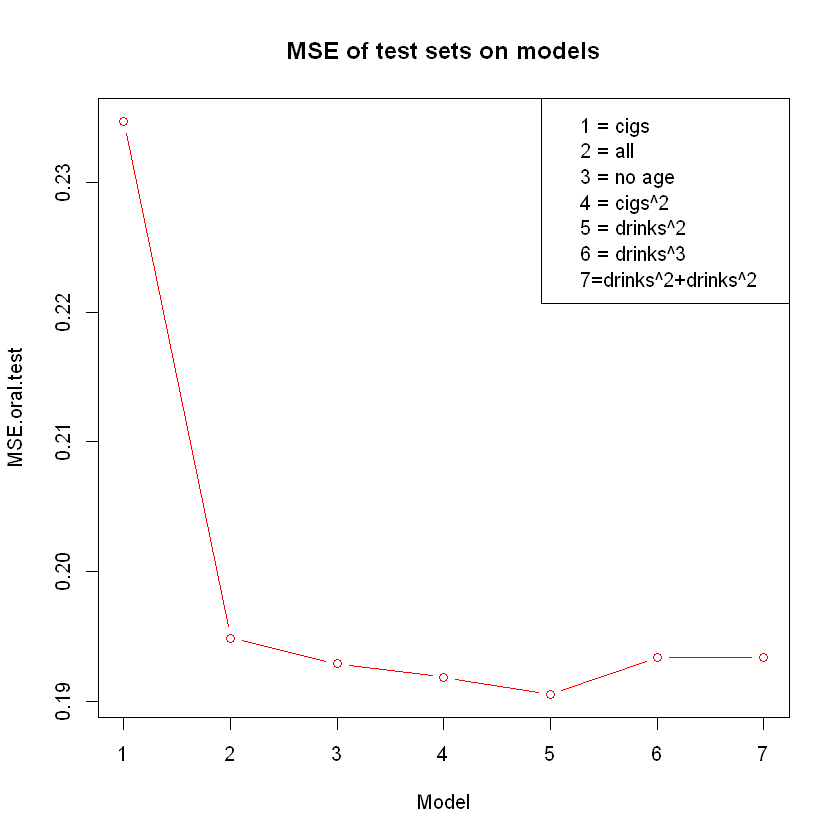

In [24]:
 set.seed(2468)
######
# Break data into train/test sets and fit pervious models
## 75% of the sample size
train.size <- floor(0.75 * nrow(oral_ca))

## set the seed to make your partition reproducible
set.seed(13)  # Will need to delete/update if I'm trying to run this simulation multiple times
train.indexes <- sample(seq_len(nrow(oral_ca)), size = train.size)

# Training/testing sets 
oc.train <- oral_ca[train.indexes, ]  # set of indexes from sample()
oc.test  <- oral_ca[-train.indexes, ] # rest of indexes

MSE.oral.train = NULL
MSE.oral.test = NULL

# fit to models described in previous parts
model.cig.train <- glm(ccstatus ~ cigs, data=oc.train, family = "binomial"(link="logit"))
pred <- predict(model.cig.train)
MSE.oral.train[1] = sum(((oc.train$ccstatus - pred)^2 ) / length(oc.train$ccstatus))
pred <- predict(model.cig.train, newdata = oc.test, type = "response")
MSE.oral.test[1] = sum(((oc.test$ccstatus - pred)^2 ) / length(oc.test$ccstatus))

model.all.train <- glm(ccstatus ~ cigs + drinks + sex + age, data=oc.train, family = "binomial"(link="logit"))
pred <- predict(model.all.train)
MSE.oral.train[2] = sum(((oc.train$ccstatus - pred)^2 ) / length(oc.train$ccstatus))
pred <- predict(model.all.train, newdata = oc.test, type = "response")
MSE.oral.test[2] = sum(((oc.test$ccstatus - pred)^2 ) / length(oc.test$ccstatus))

model.noage.train <- glm(ccstatus ~ cigs + drinks + sex, data=oc.train, family = "binomial"(link="logit"))
pred <- predict(model.noage.train)
MSE.oral.train[3] = sum(((oc.train$ccstatus - pred)^2 ) / length(oc.train$ccstatus))
pred <- predict(model.noage.train, newdata = oc.test, type = "response")
MSE.oral.test[3] = sum(((oc.test$ccstatus - pred)^2 ) / length(oc.test$ccstatus))

model.cig2.train <- glm(ccstatus ~ cigs + I(cigs^2) + drinks + sex, data=oc.train, family = "binomial"(link="logit"))
pred <- predict(model.cig2.train)
MSE.oral.train[4] = sum(((oc.train$ccstatus - pred)^2 ) / length(oc.train$ccstatus))
pred <- predict(model.cig2.train, newdata = oc.test, type = "response")
MSE.oral.test[4] = sum(((oc.test$ccstatus - pred)^2 ) / length(oc.test$ccstatus))

model.drink2.train <- glm(ccstatus ~ cigs + drinks + I(drinks^2) + sex, data=oc.train, family = "binomial"(link="logit"))
pred <- predict(model.drink2.train)
MSE.oral.train[5] = sum(((oc.train$ccstatus - pred)^2 ) / length(oc.train$ccstatus))
pred <- predict(model.drink2.train, newdata = oc.test, type = "response")
MSE.oral.test[5] = sum(((oc.test$ccstatus - pred)^2 ) / length(oc.test$ccstatus))

model.drink3.train <- glm(ccstatus ~ cigs + drinks + I(drinks^3) + sex, data=oc.train, family = "binomial"(link="logit"))
pred <- predict(model.drink3.train)
MSE.oral.train[6] = sum(((oc.train$ccstatus - pred)^2 ) / length(oc.train$ccstatus))
pred <- predict(model.drink3.train, newdata = oc.test, type = "response")
MSE.oral.test[6] = sum(((oc.test$ccstatus - pred)^2 ) / length(oc.test$ccstatus))

model.drink23.train <- glm(ccstatus ~ cigs + drinks + I(drinks^2) + I(drinks^3) + sex, data=oc.train, family = "binomial"(link="logit"))
pred <- predict(model.drink23.train)
MSE.oral.train[7] = sum(((oc.train$ccstatus - pred)^2 ) / length(oc.train$ccstatus))
pred <- predict(model.drink3.train, newdata = oc.test, type = "response")
MSE.oral.test[7] = sum(((oc.test$ccstatus - pred)^2 ) / length(oc.test$ccstatus))


# plot MSEs for different models 


plot(1:7, MSE.oral.train, type='b', col=2, xlab="Model", main="MSE of train sets on models")
legend("bottomright", legend=c("1 = cigs", "2 = all", "3 = no age", "4 = cigs^2", "5 = drinks^2", "6 = drinks^3", "7=drinks^2+drinks^2"))


plot(1:7, MSE.oral.test, type='b', col=2, xlab="Model", main="MSE of test sets on models")
legend("topright", legend=c("1 = cigs", "2 = all", "3 = no age", "4 = cigs^2", "5 = drinks^2", "6 = drinks^3", "7=drinks^2+drinks^2"))



